Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [1]:
# Download the data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-07-10 11:18:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:829::201b, 2404:6800:4009:830::201b, 2404:6800:4009:82b::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:829::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: '10_food_classes_10_percent.zip.2'

     0K .......... .......... .......... .......... ..........  0%  112K 24m23s
    50K .......... .......... .......... .......... ..........  0%  170K 20m15s
   100K .......... .......... .......... .......... ..........  0%  438K 15m35s
   150K .......... .......... .......... .......... ..........  0%  442K 13m14s
   200K .......... .......... .......... .......... ..........  0%  513K 11m39s
   250K .......... .......... .......... .......... ..........  0%  796K 10m17s
   300K .......... ..

In [2]:
# Navigating the images
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "C:/Tensorflow/10_food_classes_10_percent/train"
test_dir = "C:/Tensorflow/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing data")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images
Found 750 images belonging to 10 classes.
Testing data
Found 2500 images belonging to 10 classes.


In [5]:
# Setting up callbacks
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [6]:
# Using the Mobilenet_v2 from Tensorflow Hub
mobilenet_url = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/1"


In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as a keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [9]:
mobilenet_model = create_model(mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

In [10]:
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [11]:
from tensorflow.keras.callbacks import TensorBoard

mobilenet_history = mobilenet_model.fit(train_data_10_percent, epochs=10,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobilenetv2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20240710-112010
Epoch 1/10
24/24 [==============================] - 47s 1s/step - loss: 1.9416 - accuracy: 0.3213 - val_loss: 1.2533 - val_accuracy: 0.6484
Epoch 2/10
24/24 [==============================] - 11s 487ms/step - loss: 1.0066 - accuracy: 0.7227 - val_loss: 0.8859 - val_accuracy: 0.7368
Epoch 3/10
24/24 [==============================] - 11s 481ms/step - loss: 0.7194 - accuracy: 0.8040 - val_loss: 0.7400 - val_accuracy: 0.7848
Epoch 4/10
24/24 [==============================] - 13s 562ms/step - loss: 0.5676 - accuracy: 0.8413 - val_loss: 0.6809 - val_accuracy: 0.7880
Epoch 5/10
24/24 [==============================] - 12s 530ms/step - loss: 0.4700 - accuracy: 0.8840 - val_loss: 0.6298 - val_accuracy: 0.8096
Epoch 6/10
24/24 [==============================] - 13s 549ms/step - loss: 0.4071 - accuracy: 0.8987 - val_loss: 0.6116 - val_accuracy: 0.8092
Epoch 7/10
24/24 [==============================] - 13s 551ms/step - 

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [13]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


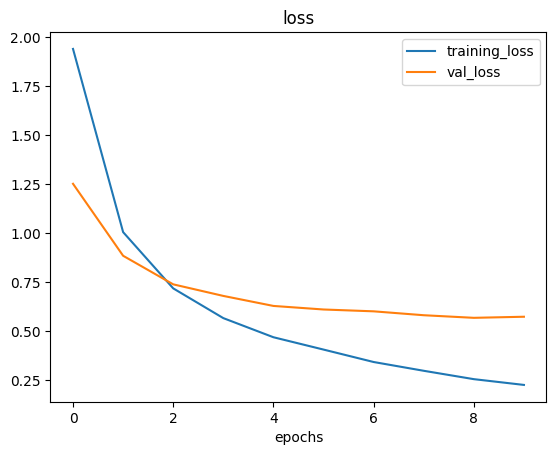

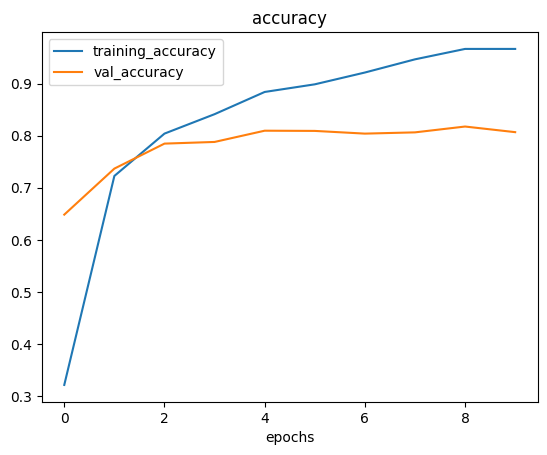

In [14]:
plot_loss_curves(mobilenet_history)

In [15]:
mobilenet_model.evaluate(test_data)

79/79 [==============================] - 9s 115ms/step - loss: 0.5746 - accuracy: 0.8068


[0.5746331810951233, 0.8068000078201294]